In [2]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from lmfit.models import GaussianModel
%matplotlib inline

In [3]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals=[];ymeas=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals.append(float(items[0]))
    ymeas.append(float(items[1]))
    
xvals = np.array(xvals[2000:2300])
ymeas = np.array(ymeas[2000:2300])

infile.close()

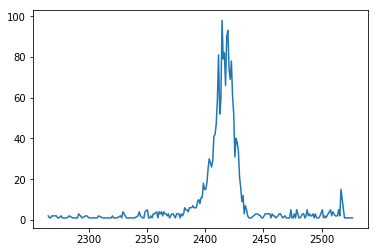

In [4]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [12]:
def gauss_fn(p0, x):
    
    amp,mu,sigma = p0
    model = GaussianModel()

    #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma)#, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod

In [13]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    ymod = gauss_fn(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [14]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess skew:
#g0 = -2.

# adjust the amplitude for the normalisation factor:
a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0)#,g0)
p0 = np.array([a0,m0,s0])#,g0])

2456.4957091383803 2414.5 10.0


In [15]:
bnds = None#((-np.infty,np.infty), (-np.infty,np.infty), (0.1,np.infty), (-10., 10.))

In [16]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [17]:
print(p1)

[1678.43729645 2415.5435587     9.18046163]


In [ ]:
yfit = gauss_fn(p1,xvals)
pl.subplot(111)
pl.scatter(xvals,ymeas)
pl.plot(xvals,yfit,c='r')
pl.show()

print(lnlike(p1, xvals, ymeas))

In [ ]:
res = (yfit - ymeas)/np.sqrt(ymeas)
pl.plot(res)
pl.ylabel(r"$\sigma$")

These residuals look a bit weird to me. I'm wondering if the data are actually well represented by a skewed Gaussian.

---

In [ ]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [ ]:
p0 = sampler.run_mcmc(pos, 500)

In [26]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

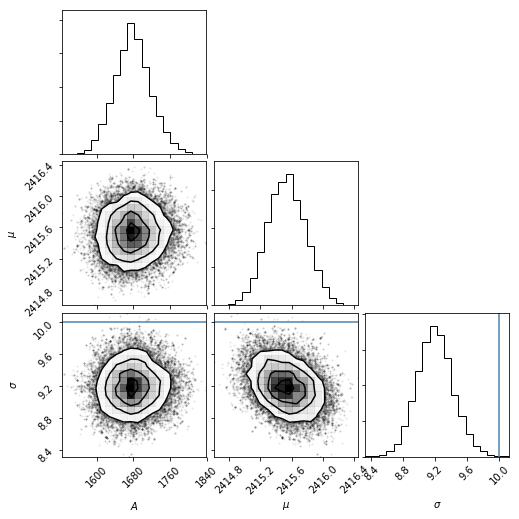

In [27]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$"],
                      truths=[a0, m0, s0])
fig.savefig("triangle.png")